In [1]:
%tensorflow_version 2.x


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

Загрузка и подготовка датасета CIFAR-10

In [95]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255

train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)


print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)


(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000, 1) int32
(10000, 1) int32


Визуализация датасета

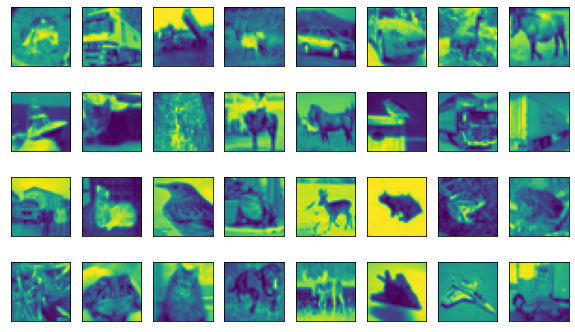

In [88]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0])
    plt.xticks([]), plt.yticks([])
plt.show()

Создание пайплайна данных

In [127]:
NUM_EPOCHS = 6
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

Создание модели CNN

In [128]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
model = Model()

Функция потерь и функция вычисления точности

In [129]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))


def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

Подготовка к обучению

In [130]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

writer = tf.summary.create_file_writer('logs/adam')

Цикл обучения модели

In [131]:
%%time
for iteration, (images, labels) in enumerate(train_ds):

  with tf.GradientTape() as tape:
      logits = model(images)
      loss_value = loss(logits, labels)
        
#Backward
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

#Calc and display loss/accuracy
if iteration % 200 == 0:
  test_logits = model(test_x[:256, ...])
  accuracy_value = accuracy(test_logits, test_y[:256, ...])
        
  print("[%4d] Accuracy: %5.2f %%" % (
      iteration, accuracy_value.numpy()*100))
        
  with writer.as_default():
    tf.summary.scalar('accuracy', accuracy_value, iteration)
    tf.summary.scalar('loss', loss_value, iteration)

CPU times: user 17min 12s, sys: 23 s, total: 17min 35s
Wall time: 10min 22s


Оценка качества модели

In [132]:
%%time

test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 10.00 %
CPU times: user 9.47 s, sys: 57.8 ms, total: 9.52 s
Wall time: 5.02 s


Функция для инференса и отображения результата предсказания

In [133]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0], cmap='gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(ans))

Запуск предсказания для изображения

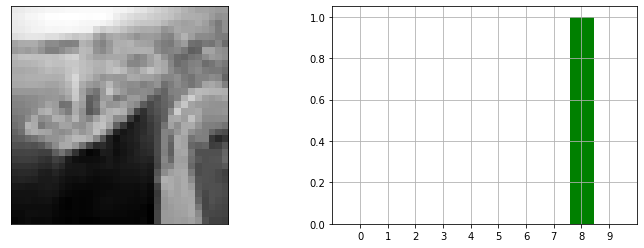

Predicted: 8
True Answer: [8]


In [134]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

print('True Answer: {}'.format(test_y[idx]))